In [1]:
!pip3 install torch torchvision torchaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 1.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 1.7 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Epoch 1, Loss: 13.719144039016834
Epoch 2, Loss: 13.44368746640871
Epoch 3, Loss: 13.164571803250759
Epoch 4, Loss: 12.87737158905688
Epoch 5, Loss: 12.605712698517943
Epoch 6, Loss: 12.329429928347361
Epoch 7, Loss: 12.028758179369591
Epoch 8, Loss: 11.861054276390899
Epoch 9, Loss: 11.608957702307393
Epoch 10, Loss: 11.473194204646049
Epoch 11, Loss: 11.379201052000196
Epoch 12, Loss: 11.104205783322561
Epoch 13, Loss: 10.960201235983869
Epoch 14, Loss: 10.977827250528678
Epoch 15, Loss: 10.859028178153277
Epoch 16, Loss: 10.74364450852648
Epoch 17, Loss: 10.645352356725459
Epoch 18, Loss: 10.568187425462462
Epoch 19, Loss: 10.473723500752621
Epoch 20, Loss: 10.424102165716157
Epoch 21, Loss: 10.256829296084616
Epoch 22, Loss: 10.210001334869604
Epoch 23, Loss: 10.055311614660909
Epoch 24, Loss: 9.935930430460319
Epoch 25, Loss: 9.846496938801497
Epoch 26, Loss: 9.741174642988247
Epoch 27, Loss: 9.54460176975607
Epoch 28, Loss: 9.5576399521862
Epoch 29, Loss: 9.442577718830794
Epoch 

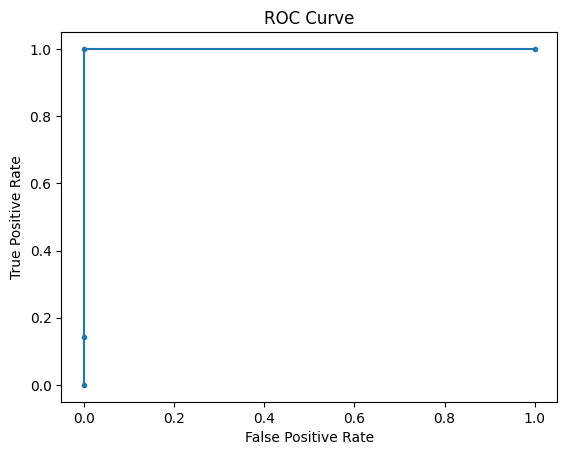

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Đọc và chuẩn bị dữ liệu
data = pd.read_csv('../../data/BCP.csv')

# Bỏ qua cột đầu tiên là ngày giờ
features = data.iloc[:, 1:]  # Bỏ cột ngày giờ nếu cần

# Chuẩn hóa các đặc trưng
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)

# Chuyển đổi dữ liệu thành tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Định nghĩa DataLoader
train_loader = DataLoader(TensorDataset(X_train, X_train), batch_size=32)

# Định nghĩa mô hình VAE với PyTorch
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU()
        )
        self.fc_mean = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mean(h), self.fc_logvar(h)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Khởi tạo mô hình, tiêu chuẩn và bộ tối ưu hóa
input_dim = X_train.shape[1]
latent_dim = 2
model = VAE(input_dim, latent_dim)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
epochs = 150
model.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        x_hat, mean, logvar = model(x)
        recon_loss = criterion(x_hat, x)
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_loader.dataset)}')

# Dự đoán và đánh giá
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test)
    reconstruction_loss = torch.mean((X_test - X_test_pred) ** 2, dim=1).numpy()

# Thiết lập ngưỡng để phát hiện bất thường
threshold = np.percentile(reconstruction_loss, 95)
pred_labels = (reconstruction_loss > threshold).astype(int)

# Đánh giá với ROC AUC
roc_auc = roc_auc_score(pred_labels, reconstruction_loss)
print(f'ROC AUC Score: {roc_auc}')

# Vẽ biểu đồ ROC
fpr, tpr, _ = roc_curve(pred_labels, reconstruction_loss)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


In [3]:
print(threshold)

1.34615345597267


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read and prepare data
dataset = pd.read_csv('../../data/BCP.csv')
features = dataset.iloc[:, 1:]  # Assuming the first column is datetime

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split data into train and test sets
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)

# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

# Initialize model, optimizer, and loss function
input_dim = X_train.shape[1]
latent_dim = 16
model = VAE(input_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters())

def loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# Train the model
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train), batch_size=batch_size)

epochs = 500
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data,) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(X_train):.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test)
    reconstruction_loss = nn.functional.mse_loss(X_test_pred, X_test, reduction='none').mean(axis=1).cpu().numpy()


Epoch 1, Loss: 14.1867
Epoch 2, Loss: 13.6508
Epoch 3, Loss: 13.2992
Epoch 4, Loss: 12.9442
Epoch 5, Loss: 12.6197
Epoch 6, Loss: 12.2938
Epoch 7, Loss: 11.8972
Epoch 8, Loss: 11.7922
Epoch 9, Loss: 11.4616
Epoch 10, Loss: 11.3393
Epoch 11, Loss: 11.1193
Epoch 12, Loss: 10.9969
Epoch 13, Loss: 10.8853
Epoch 14, Loss: 10.7266
Epoch 15, Loss: 10.6182
Epoch 16, Loss: 10.5744
Epoch 17, Loss: 10.4154
Epoch 18, Loss: 10.2261
Epoch 19, Loss: 10.2001
Epoch 20, Loss: 9.9957
Epoch 21, Loss: 9.9516
Epoch 22, Loss: 9.7517
Epoch 23, Loss: 9.7340
Epoch 24, Loss: 9.6413
Epoch 25, Loss: 9.6009
Epoch 26, Loss: 9.5863
Epoch 27, Loss: 9.4774
Epoch 28, Loss: 9.5493
Epoch 29, Loss: 9.5390
Epoch 30, Loss: 9.3738
Epoch 31, Loss: 9.3560
Epoch 32, Loss: 9.4001
Epoch 33, Loss: 9.5485
Epoch 34, Loss: 9.4514
Epoch 35, Loss: 9.5382
Epoch 36, Loss: 9.4571
Epoch 37, Loss: 9.4153
Epoch 38, Loss: 9.3233
Epoch 39, Loss: 9.4677
Epoch 40, Loss: 9.3011
Epoch 41, Loss: 9.4467
Epoch 42, Loss: 9.3779
Epoch 43, Loss: 9.4314
E

[0. 0. 0. 1.]
[0.         0.14285714 1.         1.        ]
[        inf 28.937424    1.4802326   0.20637316]


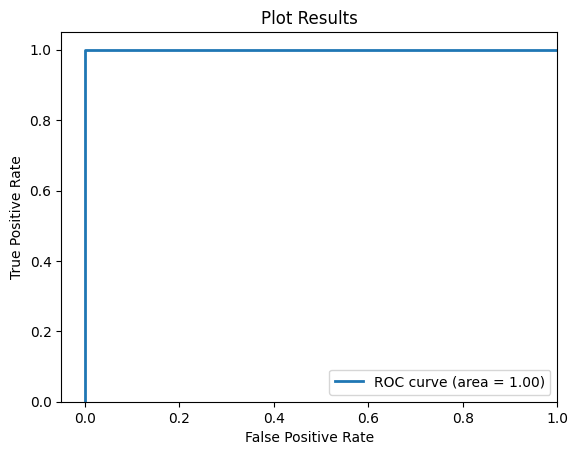

In [10]:
# Set threshold and predict anomalies
threshold = np.percentile(reconstruction_loss, 95)
pred_labels = (reconstruction_loss > threshold).astype(int)

# Evaluate model performance
# Plot ROC curve
fpr, tpr, ths = roc_curve(pred_labels, reconstruction_loss, pos_label=1)
print(fpr)
print(tpr)
print(ths)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Plot Results')
plt.legend(loc="lower right")
plt.show()

In [9]:
# Chọn cột để hiển thị, giả sử cột đó là '440FI540'
column_name = '440FI539'
dataset['timestamp'] = pd.to_datetime(dataset['Time'])  # Chuyển đổi cột thời gian
dataset.set_index('timestamp', inplace=True)

# Chuẩn hóa giá trị
scaler = StandardScaler()
dataset['scaled_value'] = scaler.fit_transform(dataset[[column_name]])

# Chia dữ liệu thành tập huấn luyện và kiểm tra
_, X_test_visualize = train_test_split(dataset['scaled_value'].values, test_size=0.2)
print(len(X_test_visualize))

140


/tmp/ipykernel_2442394/1288695951.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dataset['timestamp'] = pd.to_datetime(dataset['Time'])  # Chuyển đổi cột thời gian


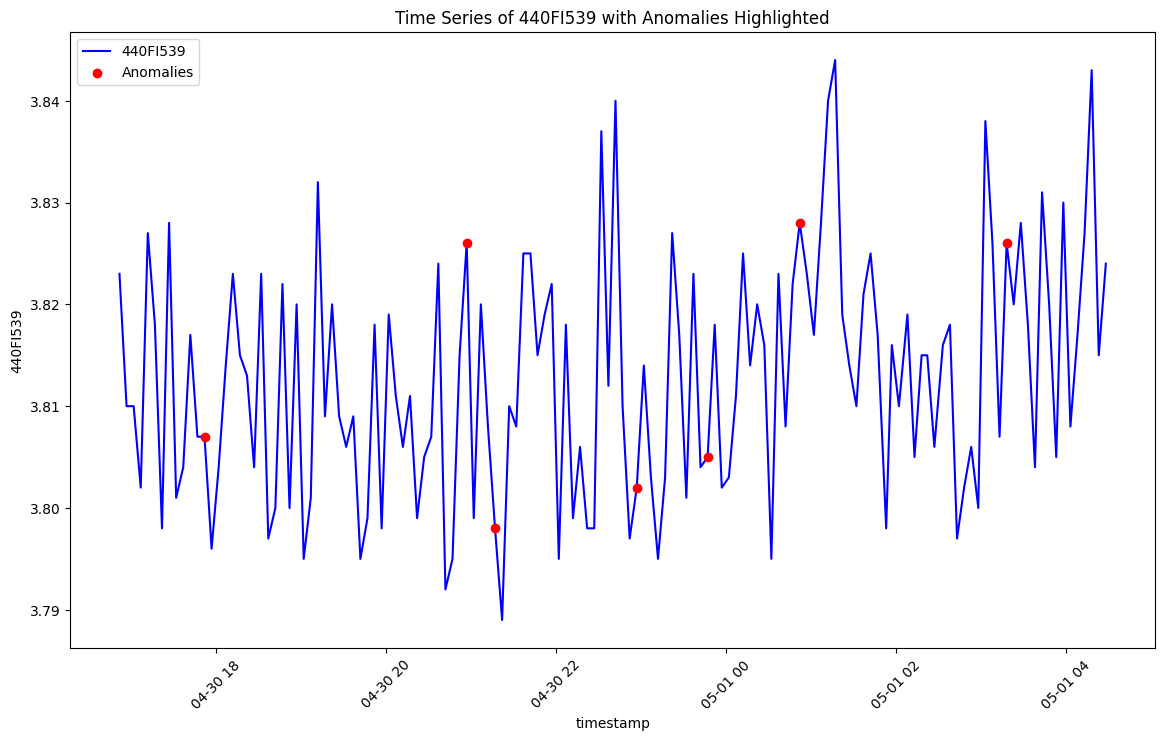

In [12]:
# Tạo DataFrame để chứa dữ liệu và kết quả phát hiện bất thường
result_df = pd.DataFrame({
    'timestamp': dataset.index[-len(X_test_visualize):],  # Lấy thời gian tương ứng từ tập kiểm tra
    'value': dataset[column_name].values[-len(X_test_visualize):],
    'reconstruction_loss': reconstruction_loss,
    'anomaly': pred_labels
})

# Vẽ biểu đồ với các điểm bất thường
plt.figure(figsize=(14, 8))

# Vẽ biểu đồ đường cho cột đã chọn
plt.plot(result_df['timestamp'], result_df['value'], label=column_name, color='blue')

# Đánh dấu các điểm bất thường bằng scatter
anomalies = result_df[result_df['anomaly'] == 1]
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies', zorder=5)

plt.xlabel('timestamp')
plt.ylabel(column_name)
plt.title(f'Time Series of {column_name} with Anomalies Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.show()

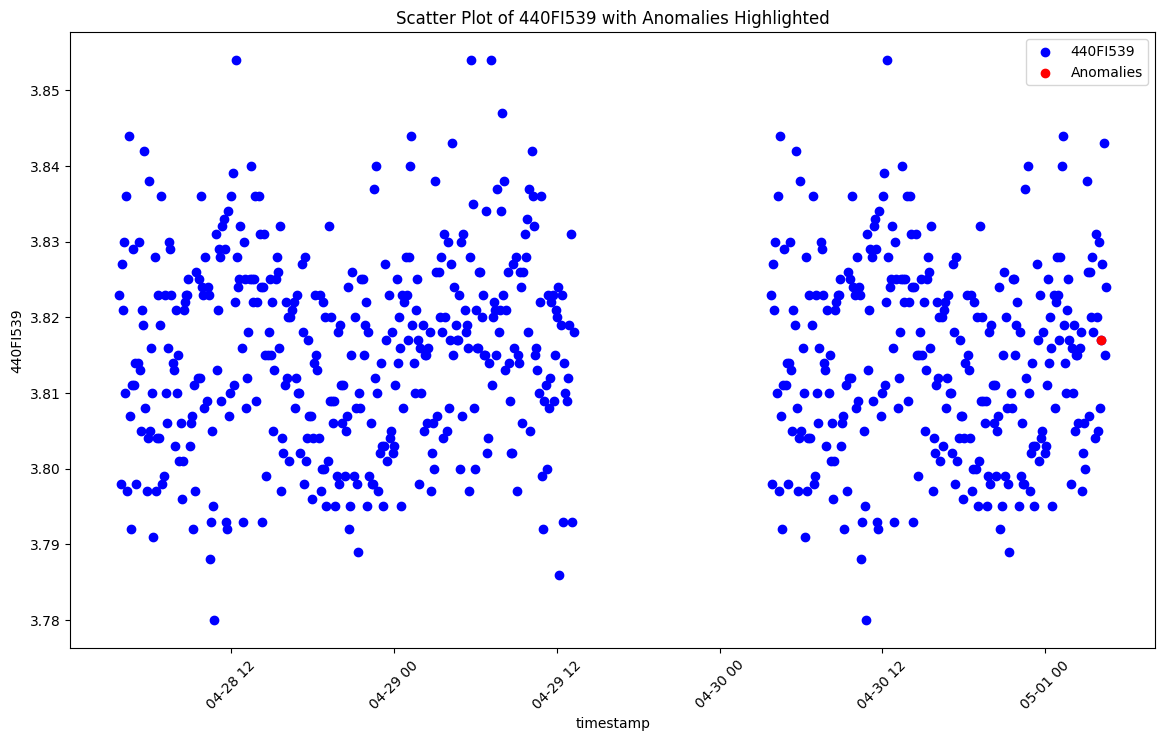

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Vẽ toàn bộ dữ liệu gốc
plt.scatter(data.index, data['440FI539'], label='440FI539', color='blue')

# Đánh dấu các điểm bất thường bằng scatter
anomalies = result_df[result_df['anomaly'] == 1]  # Chắc chắn rằng `result_df` chứa thông tin chính xác
plt.scatter(anomalies['timestamp'], anomalies['value'], color='red', label='Anomalies', zorder=5)

plt.xlabel('timestamp')
plt.ylabel('440FI539')
plt.title('Scatter Plot of 440FI539 with Anomalies Highlighted')
plt.legend()
plt.xticks(rotation=45)
plt.show()
